# Analysis of Single-Slice Imaging

### We have the middle segment from the 421 + 144 TCIA lung cancer samples formatted for analysis of Cubical Complexes

In [1]:
import numpy as np
import matplotlib.pylab as plt
import math
import os
import gudhi as gd
import pandas as pd
import PersistenceImages.persistence_images as pimg

## Functions and Persimager setup

In [2]:
#Function to isolate just the middle slice and scale values to between 0 and 1
def middle_slice(scan):
    
    nslices = len(scan)
    middle = math.ceil(nslices/2)
    middle_slice = scan[middle]
    
    return middle_slice

#Function to view the 
def view_bitmap(example):
    plt.imshow(example, cmap='gray');

In [17]:
pers_imager = pimg.PersistenceImager()
pers_imager.pixel_size = 0.1
pers_imager.birth_range = (0,1)
pers_imager.pers_range = (0,1)
pers_imager.kernel_params['sigma'][0] = [0.05, 0]
pers_imager.kernel_params['sigma'][1] = [0, 0.05]


print(pers_imager.kernel_params['sigma'][0])
print(pers_imager)

def BitmapToImageVector(bitmap, imager):
    l,w = np.shape(bitmap)
    
    cubical = gd.CubicalComplex(dimensions = [l,w], top_dimensional_cells = bitmap.flatten())
    phom = cubical.compute_persistence()
    phom_0 = cubical.persistence_intervals_in_dimension(0)
    phom_1 = cubical.persistence_intervals_in_dimension(1)
    
    pers_img_0 = imager.transform(phom_0, skew=True)
    pers_img_1 = imager.transform(phom_1, skew=True)
    
    pers_img_0 = np.resize(pers_img_0, (1, len(pers_img_0)**2))
    pers_img_1 = np.resize(pers_img_1, (1, len(pers_img_1)**2))

    #ImageVector = np.concatenate((pers_img_0[0], pers_img_1[0]), axis=0)
    
    return(phom_0, phom_1, pers_img_0, pers_img_1)

[0.05 0.  ]
PersistenceImager object: 
  pixel size: 0.1 
  resolution: (10, 10) 
  birth range: (0, 1) 
  persistence range: (0, 1) 
  weight: linear_ramp 
  kernel: bvncdf 
  weight parameters: {} 
  kernel parameters: {sigma: [[0.05 0.  ]
 [0.   0.05]]}


## Example file

In [4]:
#Load in an example file
lung_test = np.load('./Radiogenomics_Arrays/R01-010.npy')
lung_test = (lung_test - lung_test.min()) / (lung_test.max() - lung_test.min())

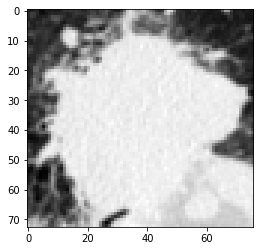

In [5]:
middle_test = middle_slice(lung_test)
view_bitmap(middle_test)

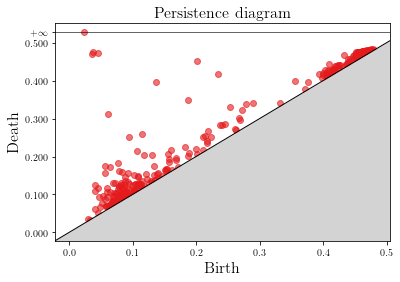

In [6]:
hom_0, hom_1, img_0, img_1 = BitmapToImageVector(middle_test, pers_imager)
gd.plot_persistence_diagram(hom_0)

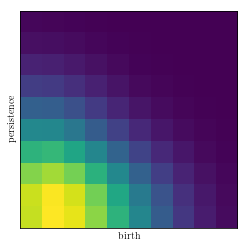

In [18]:
pers_imager.plot_image(hom_0, skew = True)

## Read in segmentations and compute persistent homology

In [8]:
#Read in Radiomics Scans
directory = os.fsencode('./Radiomics_Arrays')

all_rad_middles = []
rad_maxes = []
rad_mins = []

for file in os.listdir(directory):
    filename = './Radiomics_Arrays/' + os.fsdecode(file)
    lung = np.load(filename)
    middle = middle_slice(lung)
    all_rad_middles.append(middle)
    
    rad_maxes.append(np.amax(middle))
    rad_mins.append(np.amin(middle))
    


In [9]:
#Read in Radiogenomics Scans
directory = os.fsencode('./Radiogenomics_Arrays')

all_radg_middles = []
radg_maxes = []
radg_mins = []

for file in os.listdir(directory):
    filename = './Radiogenomics_Arrays/' + os.fsdecode(file)
    lung = np.load(filename)
    middle = middle_slice(lung)
    all_radg_middles.append(middle)
    
    radg_maxes.append(np.amax(middle))
    radg_mins.append(np.amin(middle))
    


In [10]:
#Normalize
grand_max = max(np.max(rad_maxes), np.max(radg_maxes))
grand_min = max(np.min(rad_mins), np.min(radg_mins))

all_rad_middles_normalized = (all_rad_middles - grand_min) / (grand_max - grand_min)
all_radg_middles_normalized = (all_radg_middles - grand_min) / (grand_max - grand_min)

In [11]:
#Calculate Persistent Homology of Radiomics Scans

rad_phom_0s = []
rad_phom_1s = []
rad_pimg_0s = []
rad_pimg_1s = []
rad_concatenated_images = []

for tumor in all_rad_middles_normalized:
    rad_phom_0, rad_phom_1, rad_pimg_0, rad_pimg_1 = BitmapToImageVector(tumor, pers_imager)
    
    rad_phom_0s.append(rad_phom_0)
    rad_phom_1s.append(rad_phom_1)
    rad_pimg_0s.append(rad_pimg_1)
    rad_pimg_1s.append(rad_pimg_0)
    
    imgs = np.concatenate((rad_pimg_0[0], rad_pimg_1[0]), axis=0)
    rad_concatenated_images.append(imgs)

rad_concatenated_images = np.array(rad_concatenated_images)

In [13]:
#Calculate Persistent Homology of Radiogenomics Scans

radg_phom_0s = []
radg_phom_1s = []
radg_pimg_0s = []
radg_pimg_1s = []
radg_concatenated_images = []

for tumor in all_radg_middles_normalized:
    radg_phom_0, radg_phom_1, radg_pimg_0, radg_pimg_1 = BitmapToImageVector(tumor, pers_imager)
    
    radg_phom_0s.append(radg_phom_0)
    radg_phom_1s.append(radg_phom_1)
    radg_pimg_0s.append(radg_pimg_1)
    radg_pimg_1s.append(radg_pimg_0)
    
    imgs = np.concatenate((radg_pimg_0[0], radg_pimg_1[0]), axis=0)
    radg_concatenated_images.append(imgs)

radg_concatenated_images = np.array(radg_concatenated_images)

## Read in clinical data

In [14]:
#Radiomics clinical data
rad_clinical = pd.read_csv("rad_clinic.csv")
rad_clinical = rad_clinical.drop(rad_clinical.index[127]) #Tumor 128 has no segmentation

#Radiogenomics clinical data
radg_clinical = pd.read_csv("radg_clinic.csv", skiprows = range(1,50))
radg_clinical = radg_clinical[0:146]
radg_clinical = radg_clinical.drop(radg_clinical.index[[8, 142]]) #9 and 143 have no segmentation

In [15]:
radg_clinical["Histology"] = radg_clinical['Histology'].str.lower()
rad_histology = rad_clinical.Histology
radg_histology = radg_clinical.Histology
print(rad_histology)
print(radg_histology)

0                   large cell
1      squamous cell carcinoma
2                   large cell
3      squamous cell carcinoma
4      squamous cell carcinoma
                ...           
417             adenocarcinoma
418    squamous cell carcinoma
419    squamous cell carcinoma
420    squamous cell carcinoma
421                        NaN
Name: Histology, Length: 421, dtype: object
0               adenocarcinoma
1               adenocarcinoma
2               adenocarcinoma
3      squamous cell carcinoma
4               adenocarcinoma
                ...           
140             adenocarcinoma
141             adenocarcinoma
143             adenocarcinoma
144             adenocarcinoma
145             adenocarcinoma
Name: Histology, Length: 144, dtype: object


In [16]:
print(sum(radg_histology == 'adenocarcinoma'))
print(sum(radg_histology == 'squamous cell carcinoma'))

print(sum(rad_histology == "adenocarcinoma"))
print(sum(rad_histology == 'squamous cell carcinoma'))

112
29
51
152


### Combine rad and radg datasets

In [17]:
radg_adeno = radg_histology == 'adenocarcinoma'
radg_squamous = radg_histology == 'squamous cell carcinoma'
rad_adeno = rad_histology == 'adenocarcinoma'
rad_squamous = rad_histology == 'squamous cell carcinoma'


print(sum(radg_adeno))
print(sum(radg_squamous))

print(sum(rad_adeno))
print(sum(rad_squamous))


print(sum(radg_adeno | radg_squamous))
print(sum(rad_adeno | rad_squamous))

112
29
51
152
141
203


In [18]:
radg_histology_adsq = np.array(radg_histology[radg_adeno | radg_squamous])
rad_histology_adsq = np.array(rad_histology[rad_adeno | rad_squamous])


radg_concatenated_images_adsq = radg_concatenated_images[radg_adeno | radg_squamous]
rad_concatenated_images_adsq = rad_concatenated_images[rad_adeno | rad_squamous]


histology_adsq = np.array(list(radg_histology_adsq) + list(rad_histology_adsq))
images_adsq = np.array(list(radg_concatenated_images_adsq) + list(rad_concatenated_images_adsq))

# Do Machine Learning

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from xgboost import XGBClassifier

### Radiogenomics Dataset

In [20]:
scores = []
y_pred = []

clf_xgboost = XGBClassifier(scale_pos_weight = 3)
cv = KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in cv.split(radg_concatenated_images_adsq):

    X_train, X_test = radg_concatenated_images_adsq[train_index], radg_concatenated_images_adsq[test_index]
    y_train, y_test = radg_histology_adsq[train_index], radg_histology_adsq[test_index]
    clf_xgboost.fit(X_train, y_train)
    y_pred.append(list(clf_xgboost.predict(X_test)))
    scores.append(clf_xgboost.score(X_test, y_test))
y_pred = [val for sublist in y_pred for val in sublist]

print("5-fold cross-validated accuracy: %.2f%%" % (np.mean(scores) * 100.0))
print(confusion_matrix(radg_histology_adsq, y_pred, labels=['adenocarcinoma', 'squamous cell carcinoma']))

5-fold cross-validated accuracy: 75.20%
[[101  11]
 [ 24   5]]


### Radiomics Dataset

In [21]:
scores = []
y_pred = []
clf_xgboost = XGBClassifier(scale_pos_weight = 3)
cv = KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in cv.split(rad_concatenated_images_adsq):

    X_train, X_test = rad_concatenated_images_adsq[train_index], rad_concatenated_images_adsq[test_index]
    y_train, y_test = rad_histology_adsq[train_index], rad_histology_adsq[test_index]
    clf_xgboost.fit(X_train, y_train)
    y_pred.append(list(clf_xgboost.predict(X_test)))
    scores.append(clf_xgboost.score(X_test, y_test))
y_pred = [val for sublist in y_pred for val in sublist]

print("5-fold cross-validated accuracy: %.2f%%" % (np.mean(scores) * 100.0))
print(confusion_matrix(rad_histology_adsq, y_pred, labels=['adenocarcinoma', 'squamous cell carcinoma']))

5-fold cross-validated accuracy: 71.48%
[[  6  45]
 [ 13 139]]


### Combined Dataset

In [22]:
#First we need to shuffle this dataset since otherwise k-fold will magnify batch effects.
images_adsq, histology_adsq = shuffle(images_adsq, histology_adsq)

In [23]:
scores = []
y_pred = []
clf_xgboost = XGBClassifier()
cv = KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in cv.split(images_adsq):

    X_train, X_test = images_adsq[train_index], images_adsq[test_index]
    y_train, y_test = histology_adsq[train_index], histology_adsq[test_index]
    clf_xgboost.fit(X_train, y_train)
    y_pred.append(list(clf_xgboost.predict(X_test)))
    scores.append(clf_xgboost.score(X_test, y_test))
    
y_pred = [val for sublist in y_pred for val in sublist]    
print("5-fold cross-validated accuracy: %.2f%%" % (np.mean(scores) * 100.0))
print(confusion_matrix(histology_adsq, y_pred, labels=['adenocarcinoma', 'squamous cell carcinoma']))

5-fold cross-validated accuracy: 63.07%
[[ 98  65]
 [ 62 119]]


## L1-penalized LogReg on combined dataset

In [24]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

In [25]:
scores = []
y_pred = []


clf_logreg = LogisticRegression(penalty='l1', solver='liblinear')


cv = KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in cv.split(images_adsq):

    X_train, X_test = images_adsq[train_index], images_adsq[test_index]
    y_train, y_test = histology_adsq[train_index], histology_adsq[test_index]
    clf_logreg.fit(X_train, y_train)
    y_pred.append(list(clf_logreg.predict(X_test)))
    scores.append(clf_logreg.score(X_test, y_test))
    
y_pred = [val for sublist in y_pred for val in sublist]    

print("5-fold cross-validated accuracy: %.2f%%" % (np.mean(scores) * 100.0))
print(confusion_matrix(histology_adsq, y_pred, labels=['adenocarcinoma', 'squamous cell carcinoma']))

5-fold cross-validated accuracy: 66.57%
[[ 84  79]
 [ 36 145]]
